In [1]:
def imgs_to_array(cond, path):
    imgs = []
    valid_images = [".jpg",".png"]
    for f in os.listdir(path):
        ext = os.path.splitext(f)[1]
        if ext.lower() not in valid_images:
            continue
        x = Image.open(os.path.join(path,f))
        y = x.resize((72, 72))
        p = np.array(y)
        p = p.astype('float32')
        p = p/255.0
        imgs.append(p)
        #imgs.append(Image.open(os.path.join(path,f)))
    numb = len(imgs)
    if cond == 'clean':
        lbl = np.zeros(numb)
    elif cond == 'polluted':
        lbl = np.ones(numb)
    return (imgs, lbl)

In [2]:
from PIL import Image
import os, os.path
import numpy as np
from numpy import asarray

#Create a train data and label
data = []
lbl = []

#Create permanent arrays to save img arrays
data_clean = []
data_polluted = []
#Create permanent arrays to save lbl arrays
lbl_clean = []
lbl_polluted = []

path_clean = "/Users/Davran/0_Deep_Learning_Project/Insulator Inspection/Insulator/All/Clean"
path_polluted = "/Users/Davran/0_Deep_Learning_Project/Insulator Inspection/Insulator/All/Polluted"
cond_1 = 'clean'
cond_2 = 'polluted'

(data, lbl_clean) = imgs_to_array(cond_1, path_clean)
(data_polluted, lbl_polluted) = imgs_to_array(cond_2, path_polluted)

data.extend(data_polluted)
lbl = np.concatenate((lbl_clean,lbl_polluted))

In [3]:
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras import regularizers
import tensorflow as tf

data = np.array(data)
lbl = np.array(lbl)
shuffled_idx = np.random.permutation(276)
data[:] = data[shuffled_idx]
lbl[:] = lbl[shuffled_idx]
print(data.shape)
print(lbl.shape)

(276, 72, 72, 3)
(276,)


In [4]:
##Configure the hyperparameters

image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
mlp_head_units = [32]  # Size of the dense layers of the final classifier

In [5]:
## Use data augmentation
from tensorflow.keras import Sequential
data_augmentation = Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.

data_augmentation.layers[0].adapt(data)

In [6]:
## Implement multilayer perceptron (MLP)

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [7]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


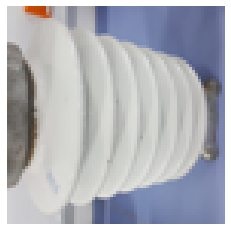

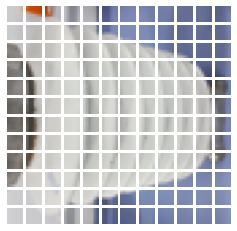

In [8]:
## Let's display patches for a sample image

import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = data[np.random.choice(range(data.shape[0]))]
plt.imshow(image.astype("float32"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("float32"))
    plt.axis("off")

In [9]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [12]:
## Build the ViT model
from tensorflow.keras import Model
from tensorflow.keras import losses
import tensorflow_addons as tfa

def create_vit_classifier(dropout_rate, learning_rate, epsilon, transformer_layers, num_heads):
    input_shape = (72, 72, 3)
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=epsilon)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=epsilon)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=epsilon)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(dropout_rate)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=dropout_rate)
    # Classify outputs.
    logits = layers.Dense(1)(features)
    # Create the Keras model.
    model = Model(inputs=inputs, outputs=logits)
    weight_decay=0.0001
  ###################################################################################  
    model.compile(loss='binary_crossentropy',
                  optimizer=tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay = weight_decay),
                  metrics=['acc'])
    ##loss='binary_crossentropy'
    return model

In [19]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

#model = KerasClassifier(build_fn=define_model,verbose=1)
model = KerasClassifier(build_fn=create_vit_classifier, verbose=1)
#model = create_vit_classifier()

gridcvs = {}
dropout_rate = [0.1, 0.2]
learning_rate =  [1e-2, 1e-3]
batch_size = [8, 16, 32]
epochs = [150]
epsilon = [1e-5, 1e-6]
transformer_layers = [1, 2, 4]
num_heads = [1, 2, 4]

param_grid = dict(dropout_rate=dropout_rate, learning_rate = learning_rate, epsilon=epsilon, 
                  transformer_layers=transformer_layers, num_heads=num_heads,
                  batch_size=batch_size,
                  epochs=epochs)


<ipython-input-19-f5ab94ba1055>:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  model = KerasClassifier(build_fn=create_vit_classifier, verbose=1)


In [20]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.callbacks import EarlyStopping
from tune_sklearn import TuneSearchCV


stopper = EarlyStopping(monitor='loss', patience=5, verbose=1)
fit_params = dict(callbacks=[stopper])

#grid = TuneSearchCV(estimator=model, param_distributions=param_grid, cv=5,  use_gpu =True)

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

In [ ]:
grid_result = grid.fit(data, lbl, **fit_params)

Epoch 1/150
28/28 [==============================] - 85s 322ms/step - loss: 4.7588 - acc: 0.6818: 0s - loss: 5.8085 - ac
Epoch 2/150
28/28 [==============================] - 6s 204ms/step - loss: 4.4684 - acc: 0.7091
Epoch 3/150
28/28 [==============================] - 0s 17ms/step - loss: 3.9088 - acc: 0.7455
Epoch 4/150
28/28 [==============================] - 5s 179ms/step - loss: 3.7694 - acc: 0.7545
Epoch 5/150
28/28 [==============================] - 0s 16ms/step - loss: 4.1191 - acc: 0.7318
Epoch 6/150
28/28 [==============================] - 5s 181ms/step - loss: 3.9781 - acc: 0.7409
Epoch 7/150
28/28 [==============================] - 0s 16ms/step - loss: 4.2593 - acc: 0.7227
Epoch 8/150
28/28 [==============================] - 5s 180ms/step - loss: 5.7321 - acc: 0.6273
Epoch 9/150
28/28 [==============================] - 0s 16ms/step - loss: 6.9954 - acc: 0.5455
Epoch 00009: early stopping
7/7 [==============================] - 1s 5ms/step - loss: 5.4901 - acc: 0.6429
Epoch 1

7/7 [==============================] - 6s 22ms/step - loss: 3.6044 - acc: 0.7636
Epoch 1/150
28/28 [==============================] - 12s 226ms/step - loss: 4.8422 - acc: 0.6697
Epoch 2/150
28/28 [==============================] - 1s 24ms/step - loss: 4.1409 - acc: 0.7285
Epoch 3/150
28/28 [==============================] - 6s 209ms/step - loss: 4.0711 - acc: 0.7330
Epoch 4/150
28/28 [==============================] - 5s 203ms/step - loss: 4.2099 - acc: 0.7240
Epoch 5/150
28/28 [==============================] - 6s 207ms/step - loss: 4.1401 - acc: 0.7285
Epoch 6/150
28/28 [==============================] - 1s 24ms/step - loss: 4.1401 - acc: 0.7285
Epoch 7/150
28/28 [==============================] - 7s 231ms/step - loss: 4.1401 - acc: 0.7285
Epoch 8/150
28/28 [==============================] - 6s 218ms/step - loss: 4.1401 - acc: 0.7285
Epoch 00008: early stopping
7/7 [==============================] - 5s 17ms/step - loss: 3.0498 - acc: 0.8000
Epoch 1/150
28/28 [========================

28/28 [==============================] - 0s 16ms/step - loss: 4.7915 - acc: 0.6864
Epoch 4/150
28/28 [==============================] - 5s 184ms/step - loss: 4.1605 - acc: 0.7273 2s - loss: 3.9099 - acc: 0.7
Epoch 5/150
28/28 [==============================] - 0s 16ms/step - loss: 4.0203 - acc: 0.7364
Epoch 6/150
28/28 [==============================] - 6s 207ms/step - loss: 4.0203 - acc: 0.7364
Epoch 7/150
28/28 [==============================] - 6s 207ms/step - loss: 4.0203 - acc: 0.7364
Epoch 8/150
28/28 [==============================] - 0s 17ms/step - loss: 4.0203 - acc: 0.7364
Epoch 9/150
28/28 [==============================] - 6s 217ms/step - loss: 4.0203 - acc: 0.7364
Epoch 10/150
28/28 [==============================] - 6s 206ms/step - loss: 4.0203 - acc: 0.7364
Epoch 11/150
28/28 [==============================] - 0s 16ms/step - loss: 4.0203 - acc: 0.7364
Epoch 12/150
28/28 [==============================] - 5s 187ms/step - loss: 4.0203 - acc: 0.7364
Epoch 13/150
28/28 [====

28/28 [==============================] - 5s 187ms/step - loss: 4.5604 - acc: 0.7014
Epoch 00006: early stopping
7/7 [==============================] - 5s 11ms/step - loss: 4.1653 - acc: 0.7273
Epoch 1/150
28/28 [==============================] - 12s 227ms/step - loss: 5.3587 - acc: 0.6516
Epoch 2/150
28/28 [==============================] - 6s 220ms/step - loss: 4.8714 - acc: 0.6833
Epoch 3/150
28/28 [==============================] - 1s 27ms/step - loss: 3.5389 - acc: 0.7692
Epoch 4/150
28/28 [==============================] - 6s 227ms/step - loss: 3.4691 - acc: 0.7738
Epoch 5/150
28/28 [==============================] - 6s 206ms/step - loss: 3.4691 - acc: 0.7738
Epoch 6/150
28/28 [==============================] - 1s 23ms/step - loss: 3.5389 - acc: 0.7692
Epoch 7/150
28/28 [==============================] - 5s 194ms/step - loss: 3.4691 - acc: 0.7738
Epoch 8/150
28/28 [==============================] - 5s 193ms/step - loss: 3.4691 - acc: 0.7738
Epoch 9/150
28/28 [=====================

28/28 [==============================] - 5s 198ms/step - loss: 11.6986 - acc: 0.2409
Epoch 3/150
28/28 [==============================] - 0s 16ms/step - loss: 10.3662 - acc: 0.3182
Epoch 4/150
28/28 [==============================] - 5s 184ms/step - loss: 10.0867 - acc: 0.3455
Epoch 5/150
28/28 [==============================] - 0s 16ms/step - loss: 10.4389 - acc: 0.3227
Epoch 6/150
28/28 [==============================] - 5s 183ms/step - loss: 10.9305 - acc: 0.2909
Epoch 7/150
28/28 [==============================] - 0s 16ms/step - loss: 6.7928 - acc: 0.5591
Epoch 8/150
28/28 [==============================] - 5s 21ms/step - loss: 4.3183 - acc: 0.7182
Epoch 9/150
28/28 [==============================] - 5s 195ms/step - loss: 4.6633 - acc: 0.6955
Epoch 10/150
28/28 [==============================] - 1s 18ms/step - loss: 3.8283 - acc: 0.7500
Epoch 11/150
28/28 [==============================] - 5s 191ms/step - loss: 3.9669 - acc: 0.7409
Epoch 12/150
28/28 [==============================

28/28 [==============================] - 5s 201ms/step - loss: 3.5881 - acc: 0.7647
Epoch 10/150
28/28 [==============================] - 5s 202ms/step - loss: 3.5881 - acc: 0.7647
Epoch 11/150
28/28 [==============================] - 1s 23ms/step - loss: 3.5881 - acc: 0.7647
Epoch 12/150
28/28 [==============================] - 5s 197ms/step - loss: 3.5881 - acc: 0.7647
Epoch 13/150
28/28 [==============================] - 5s 189ms/step - loss: 3.5881 - acc: 0.7647
Epoch 14/150
28/28 [==============================] - 1s 23ms/step - loss: 3.5881 - acc: 0.7647
Epoch 15/150
28/28 [==============================] - 5s 192ms/step - loss: 3.5881 - acc: 0.7647
Epoch 00015: early stopping
7/7 [==============================] - 1s 10ms/step - loss: 5.2679 - acc: 0.6545
Epoch 1/150
28/28 [==============================] - 12s 221ms/step - loss: 3.7693 - acc: 0.7421
Epoch 2/150
28/28 [==============================] - 1s 24ms/step - loss: 3.4009 - acc: 0.7783
Epoch 3/150
28/28 [================

28/28 [==============================] - 6s 223ms/step - loss: 3.5381 - acc: 0.7692
Epoch 4/150
28/28 [==============================] - 6s 203ms/step - loss: 3.5397 - acc: 0.7692
Epoch 5/150
28/28 [==============================] - 6s 205ms/step - loss: 3.6079 - acc: 0.7647
Epoch 6/150
28/28 [==============================] - 6s 210ms/step - loss: 3.6087 - acc: 0.7647
Epoch 7/150
28/28 [==============================] - 11s 402ms/step - loss: 3.6801 - acc: 0.7602
Epoch 8/150
28/28 [==============================] - 6s 227ms/step - loss: 3.6087 - acc: 0.7647
Epoch 00008: early stopping
7/7 [==============================] - 11s 805ms/step - loss: 3.0626 - acc: 0.8000
Epoch 1/150
28/28 [==============================] - 6s 16ms/step - loss: 3.7878 - acc: 0.7500
Epoch 2/150
28/28 [==============================] - 6s 205ms/step - loss: 4.0546 - acc: 0.7273
Epoch 3/150
28/28 [==============================] - 0s 17ms/step - loss: 5.6028 - acc: 0.6318
Epoch 4/150
28/28 [===================

Epoch 2/150
28/28 [==============================] - 6s 29ms/step - loss: 3.6138 - acc: 0.7602
Epoch 3/150
28/28 [==============================] - 5s 199ms/step - loss: 3.8895 - acc: 0.7466
Epoch 4/150
28/28 [==============================] - 5s 192ms/step - loss: 3.4715 - acc: 0.7738
Epoch 5/150
28/28 [==============================] - 1s 22ms/step - loss: 3.8261 - acc: 0.7466
Epoch 6/150
28/28 [==============================] - 5s 193ms/step - loss: 3.5406 - acc: 0.7692
Epoch 7/150
28/28 [==============================] - 5s 191ms/step - loss: 3.3362 - acc: 0.7783
Epoch 8/150
28/28 [==============================] - 1s 22ms/step - loss: 3.4009 - acc: 0.7783
Epoch 9/150
28/28 [==============================] - 5s 194ms/step - loss: 3.4009 - acc: 0.7783
Epoch 10/150
28/28 [==============================] - 5s 197ms/step - loss: 3.4009 - acc: 0.7783
Epoch 11/150
28/28 [==============================] - 1s 22ms/step - loss: 3.4009 - acc: 0.7783
Epoch 12/150
28/28 [======================

28/28 [==============================] - 0s 16ms/step - loss: 4.0926 - acc: 0.7318
Epoch 10/150
28/28 [==============================] - 6s 208ms/step - loss: 4.0203 - acc: 0.7364
Epoch 11/150
28/28 [==============================] - 0s 16ms/step - loss: 4.0203 - acc: 0.7364
Epoch 00011: early stopping
7/7 [==============================] - 6s 8ms/step - loss: 3.5400 - acc: 0.7679
Epoch 1/150
28/28 [==============================] - 24s 219ms/step - loss: 3.5540 - acc: 0.7557
Epoch 2/150
28/28 [==============================] - 0s 16ms/step - loss: 3.6579 - acc: 0.7602
Epoch 3/150
28/28 [==============================] - 5s 197ms/step - loss: 3.6579 - acc: 0.7602
Epoch 4/150
28/28 [==============================] - 0s 15ms/step - loss: 3.6579 - acc: 0.7602
Epoch 5/150
28/28 [==============================] - 5s 199ms/step - loss: 3.5881 - acc: 0.7647
Epoch 6/150
28/28 [==============================] - 0s 16ms/step - loss: 3.6579 - acc: 0.7602
Epoch 00006: early stopping
7/7 [=========

28/28 [==============================] - 5s 197ms/step - loss: 4.1401 - acc: 0.7285
Epoch 13/150
28/28 [==============================] - 5s 184ms/step - loss: 4.1401 - acc: 0.7285
Epoch 00013: early stopping
7/7 [==============================] - 10s 762ms/step - loss: 3.0498 - acc: 0.8000
Epoch 1/150
28/28 [==============================] - 6s 24ms/step - loss: 11.5271 - acc: 0.2489
Epoch 2/150
28/28 [==============================] - 5s 200ms/step - loss: 11.5164 - acc: 0.2534
Epoch 3/150
28/28 [==============================] - 5s 199ms/step - loss: 11.5164 - acc: 0.2534
Epoch 4/150
28/28 [==============================] - 5s 195ms/step - loss: 11.5164 - acc: 0.2534
Epoch 5/150
28/28 [==============================] - 1s 22ms/step - loss: 11.5164 - acc: 0.2534
Epoch 6/150
28/28 [==============================] - 5s 195ms/step - loss: 11.5164 - acc: 0.2534
Epoch 7/150
28/28 [==============================] - 6s 215ms/step - loss: 11.5164 - acc: 0.2534
Epoch 8/150
28/28 [============

28/28 [==============================] - 6s 203ms/step - loss: 3.9509 - acc: 0.7409
Epoch 10/150
28/28 [==============================] - 6s 211ms/step - loss: 3.6337 - acc: 0.7591
Epoch 11/150
28/28 [==============================] - 0s 16ms/step - loss: 3.8363 - acc: 0.7500
Epoch 12/150
28/28 [==============================] - 7s 244ms/step - loss: 3.9072 - acc: 0.7455
Epoch 13/150
28/28 [==============================] - 6s 210ms/step - loss: 3.5558 - acc: 0.7682
Epoch 14/150
28/28 [==============================] - 5s 202ms/step - loss: 3.5558 - acc: 0.7682
Epoch 15/150
28/28 [==============================] - 0s 16ms/step - loss: 3.7662 - acc: 0.7545
Epoch 16/150
28/28 [==============================] - 5s 195ms/step - loss: 3.7662 - acc: 0.7545
Epoch 17/150
28/28 [==============================] - 5s 187ms/step - loss: 3.6259 - acc: 0.7636
Epoch 18/150
28/28 [==============================] - 0s 16ms/step - loss: 3.6968 - acc: 0.7591
Epoch 00018: early stopping
7/7 [=============

In [18]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.742662 using {'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 150, 'epsilon': 1e-06, 'learning_rate': 0.001, 'num_heads': 4, 'transformer_layers': 4}
